In [1]:
import networkx as nx
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score

import numpy as np
import pandas as pd
from datetime import datetime

from collections import Counter
import itertools

from math import comb, ceil
import random
import string

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import multiprocessing as mp

import pickle

import sys
sys.path.insert(1, '../scripts')
import modeling

import importlib
importlib.reload(modeling)

import matplotlib.ticker as plticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

In [79]:
max_nodes_to_connect = 1
repetition = 32
n_agents = 2
last_step = 10000

n_nodes_to_connect = list(np.array([[i]*repetition for i in range(1,max_nodes_to_connect+1)]).flatten())

simulation_count = repetition * len(np.unique(n_nodes_to_connect))

params = [*zip([*range(simulation_count)], n_nodes_to_connect, [n_agents] * simulation_count, [last_step] * simulation_count)]

In [94]:
pool = mp.Pool(processes=32)
results = pool.starmap(modeling.simulate_multiple_agents, params, chunksize=1)
pool.close()

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

KeyboardInterrupt: 

# Two Agents Simulation

In [6]:
max_nodes_to_connect = 1
repetition = 64
last_step = 100000
n_nodes_to_connect = 1
n_agents = 2
m = 15

results = {}

for n_beliefs in [4,5,6,7]:
    simulation_count = repetition * len([n_beliefs])
    random_states = [np.random.randint(0, 10000000) for i in range(simulation_count)]    

    params = [*zip([*range(simulation_count)], 
                random_states,
                modeling.flatten([[n]*repetition for n in [n_beliefs]]), 
                [m]*simulation_count,
                [n_nodes_to_connect]*simulation_count,
                [n_agents]*simulation_count,
                [last_step]*simulation_count)]

    pool = mp.Pool(processes=32)
    temp = pool.starmap(modeling.simulate_multiple_agents, params, chunksize=1)
    pool.close()

    results[n_beliefs] = temp

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
with open(f'../data/results_two_agents_{dt_string}.pkl', 'wb') as f:
    pickle.dump(results, f)

100%|██████████| 100001/100001 [06:21<00:00, 262.12it/s]


In [10]:
results[4][10]

{'sim_no': 10,
 'n_nodes_to_connect': 1,
 'track': {0: {'count_unique_belief_networks': 2,
   'preference_congruence': 0.46206545330326115,
   'preference_similarity': 0.46206545330326115,
   'interpretative_dist': 0.06537204504606378,
   'internal_energy': -0.04720936506612605},
  1000: {'count_unique_belief_networks': 1,
   'preference_congruence': 1.0,
   'preference_similarity': 1.0,
   'interpretative_dist': 0.1770195547544832,
   'internal_energy': 2.0},
  2000: {'count_unique_belief_networks': 1,
   'preference_congruence': 1.0,
   'preference_similarity': 1.0,
   'interpretative_dist': 0.09126086182739167,
   'internal_energy': 2.0},
  3000: {'count_unique_belief_networks': 1,
   'preference_congruence': 1.0,
   'preference_similarity': 1.0,
   'interpretative_dist': 0.09196980828310528,
   'internal_energy': 2.0},
  4000: {'count_unique_belief_networks': 1,
   'preference_congruence': 1.0,
   'preference_similarity': 1.0,
   'interpretative_dist': 0.08931126608864924,
   'inte

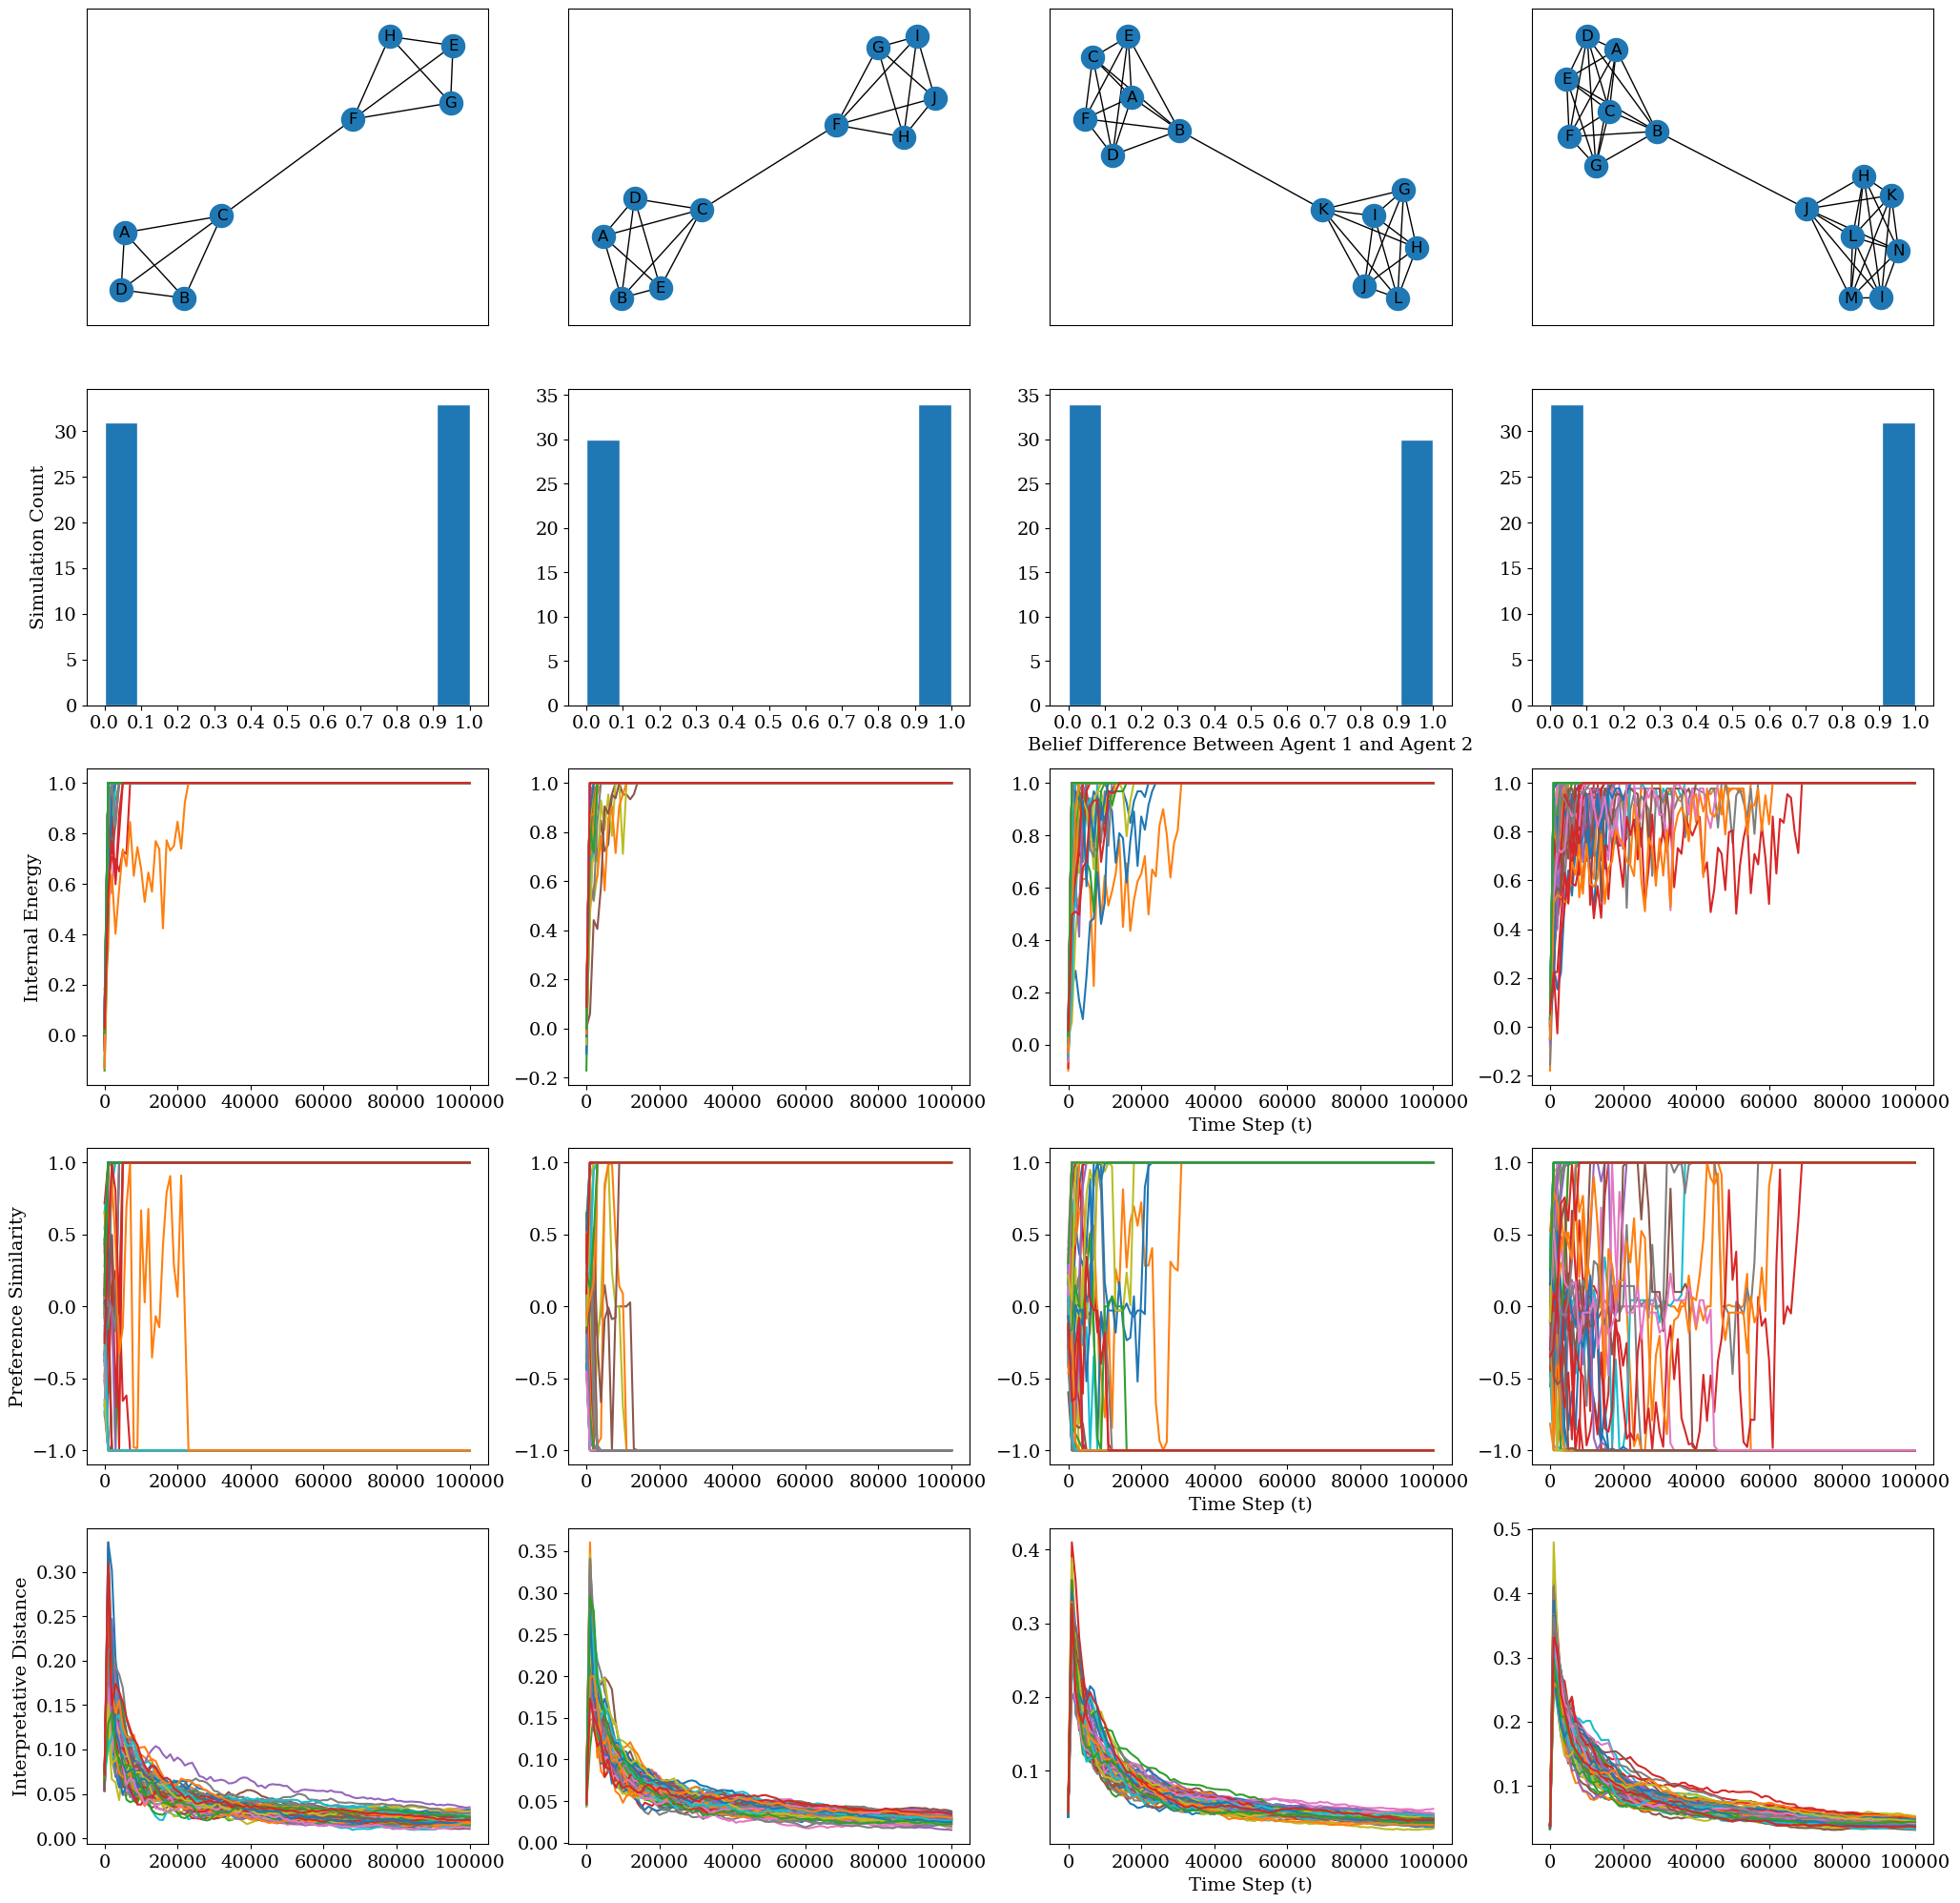

In [17]:
fig, axs = plt.subplots(5,4,figsize=(25,25))

loc = plticker.MultipleLocator(base=.1)

for col_idx, n_beliefs in zip([0,1,2,3], [4,5,6,7]):

        bn1 = modeling.create_belief_network(m = m,
                                        n_beliefs = n_beliefs,
                                        complete = True)

        bn2 = bn1.copy()
        bn2 = nx.relabel_nodes(bn2,{l1:l2 for l1,l2 in zip([*bn1.nodes],string.ascii_uppercase[len(bn1):len(bn1)+len(bn2)])})
        bn_composed = modeling.compose_networks(bn1=bn1, bn2=bn2, n_nodes_to_connect = 1, random=False)

        nx.draw_networkx(bn_composed, ax=axs[0][col_idx])

        axs[1][col_idx].hist([sum(abs(r['track'][100000]['belief_networks'][0]-r['track'][100000]['belief_networks'][1]))/(n_beliefs*2*2) for r in results[n_beliefs]],
                                bins=11,
                                edgecolor='white')
        axs[1][col_idx].xaxis.set_major_locator(loc)
        
        temp = pd.DataFrame([r['track'] for r in results[n_beliefs]]).T

        for row_idx, metric in zip([2,3,4], ['internal_energy','preference_similarity','interpretative_dist']):
                for s in temp.columns:
                        if metric == 'internal_energy':
                                axs[row_idx][col_idx].plot(temp[s].apply(lambda x: x[metric]/2))
                        else:
                                axs[row_idx][col_idx].plot(temp[s].apply(lambda x: x[metric]))

# set x and y labels
xlabels = ['Belief Difference Between Agent 1 and Agent 2', 'Time Step (t)', 'Time Step (t)', 'Time Step (t)']
ylabels = ['Simulation Count', 'Internal Energy', 'Preference Similarity', 'Interpretative Distance']
for col_idx, xlabel, ylabel in zip([1,2,3,4], xlabels, ylabels):
        axs[col_idx][0].set_ylabel(ylabel)
        axs[col_idx][2].set_xlabel(xlabel)
        
        axs[col_idx]

#axs[1][col_idx].grid(alpha=.3)

fig.get_tight_layout()
fig.show()